In [55]:
import numpy as np
import scipy as sp
import graph_cut
from skimage import io, color
import matplotlib.pyplot as plt
import time 
from generate_data import generate_data

%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
def show(M, title='', name='', path='Images/', save=False):
    plt.imshow(M)
    plt.title(title, size=18)
    plt.yticks([])
    plt.xticks([])
    if save:
        plt.savefig("data/"+title+'.png')

In [80]:
def alpha_expantion_routine(unary, vertC, horC, metric, maxIter=500, display=False, numStart=1, randOrder=False):
    N, M, K = unary.shape
    current_labels = np.random.randint(0, K, size=(N, M))
    bigNumber = 1e30
    energy = np.array([])
   
    curLabel = 0
    for i in range(maxIter):
        curLabel = (curLabel + 1) % K
        unary_up = unary.reshape(N * M, K)[np.arange(N * M), current_labels.ravel()].reshape(N, M)
        unary_up[current_labels == curLabel] = bigNumber
       
        unary_down = unary.reshape(N * M, K)[np.arange(N * M), curLabel].reshape(N, M)
       
        ### Vertical potentials
       
        phi_00_vert = vertC.ravel() * metric[current_labels[:-1, :].ravel(), current_labels[1:, :].ravel()]
        phi_01_vert = vertC.ravel() * metric[current_labels[:-1, :].ravel(), curLabel]
        phi_10_vert = vertC.ravel() * metric[curLabel, current_labels[1:, :].ravel()]
       
        # unary_down[:-1, :] += phi_00_vert.reshape((N - 1, M))
        unary_up[:-1, :] += (phi_01_vert - phi_10_vert + phi_00_vert).reshape((N - 1, M)) / 2
        unary_up[1:, :] += (phi_01_vert - phi_10_vert + phi_00_vert).reshape((N - 1, M)) / 2
       
        phi_01_vert = (phi_01_vert + phi_10_vert - phi_00_vert) / 2
       
        # Gorizontal potentials
       
       
        phi_00_hor = horC.ravel() * metric[current_labels[:, :-1].ravel(), current_labels[:, 1:].ravel()]
        phi_01_hor = horC.ravel() * metric[current_labels[:, :-1].ravel(), curLabel]
        phi_10_hor = horC.ravel() * metric[curLabel, current_labels[:, 1:].ravel()]
       
        #unary_down[:, :-1] += phi_00_hor.reshape((N, M - 1))
        unary_up[:, :-1] += (phi_01_hor - phi_10_hor + phi_00_hor).reshape((N, M - 1)) / 2
        unary_up[:, 1:] += (phi_01_hor - phi_10_hor + phi_00_hor).reshape((N, M - 1)) / 2
       
        phi_01_hor = (phi_01_hor + phi_10_hor - phi_00_hor) / 2
       
        ###
       
        term_weights = np.vstack((unary_up.ravel(), unary_down.ravel()))
       
       
        vert_weights = np.vstack((np.arange((N - 1) * M), M + np.arange((N - 1) * M), phi_01_vert, phi_01_vert))
        hor_weights = np.vstack((np.arange(N * M).reshape((N, M))[:, :-1].ravel(),
                                 np.arange(N * M).reshape((N, M))[:, 1:].ravel(), phi_01_hor, phi_01_hor))                        
       
        edge_weights = np.hstack((vert_weights, hor_weights))
       
        # print((edge_weights >= 0).all(), np.min(term_weights))
       
        cut, labels = graph_cut.graph_cut(term_weights.T, edge_weights.T)
        labels = labels.reshape((N, M))
        current_labels[labels == 0] = curLabel
        energy = np.append(energy, cut)    
        plt.imshow(current_labels, cmap="Greys_r")
        plt.show()
       
    return current_labels.ravel(), energy    

In [ ]:
def collage(images, masks, method='a'):
    eps = 1e-5
    images = np.array(np.atleast_3d(images))
    k, n, m = images.shape[:3]
       
    # Metric
    metric = np.ones((k,k)) - np.eye(k)
    
    # Unary potential
    psi1 = np.zeros((n, m, k))
    for i, mask in enumerate(masks):
        psi1[seed, :] = np.inf
        psi1[seed, i] = 0
     
    # Pairwise potentials
    dV = (images[:, 1:] - images[:, :-1]) + eps
    dH = (images[:, :, 1:] - images[:, :, :-1]) + eps
    psi2V = dV.std(0).mean(2)
    psi2H = dH.std(0).mean(2)
 
    if method == 'a':
        mask, energy = alphaExpansionGridPotts(psi1, psi2V, psi2H, metric, maxIter=2 * k)
    else:
        print "ab method is not implemented"
        
    image = images.reshape(k, -1, 3)[mask, np.arange(n * m)]
    image = image.reshape(n, m, 3)

    return image, mask

In [77]:
images = np.load("Images/2photo/images.npy")
seeds = np.load("Images/2photo/masks.npy")

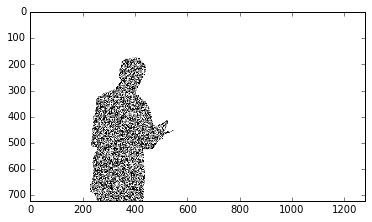

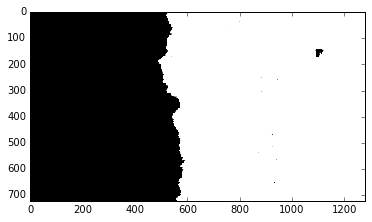

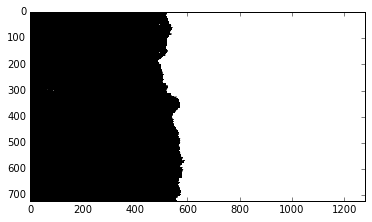

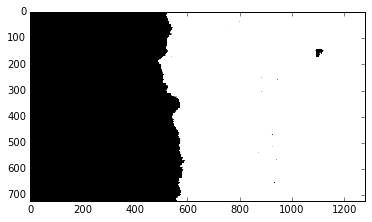

In [79]:
image, mask = stichImages(images, seeds)

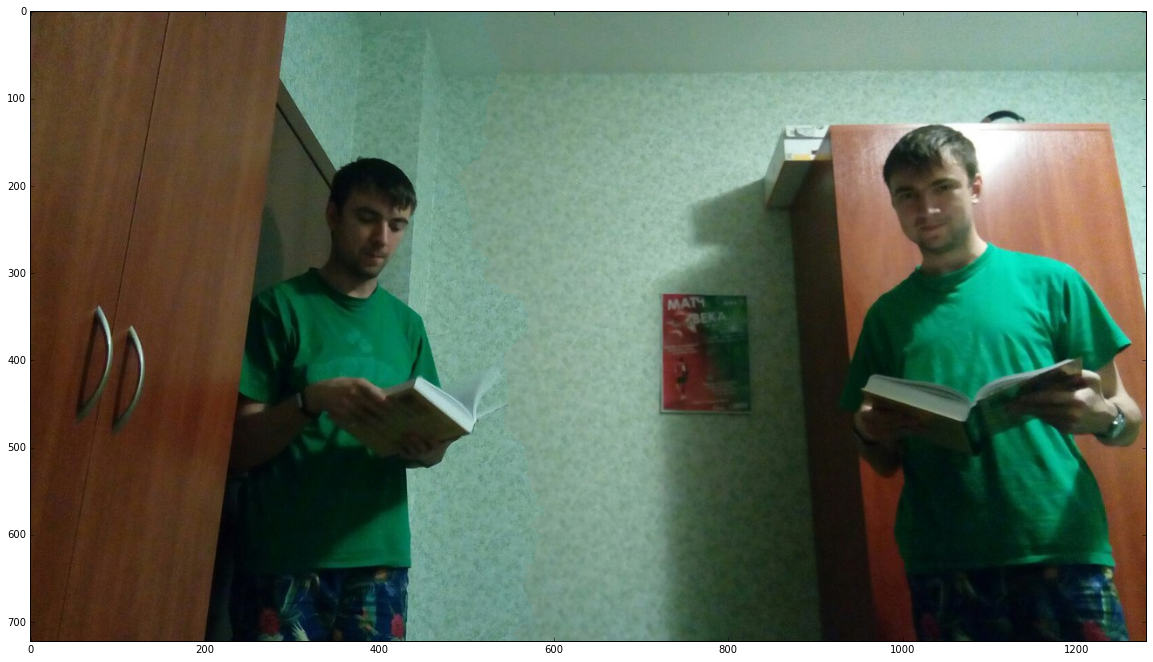

In [64]:
plt.figure(figsize=(20, 12))

plt.imshow(image)
#plt.savefig("optimal2.png")
plt.show()

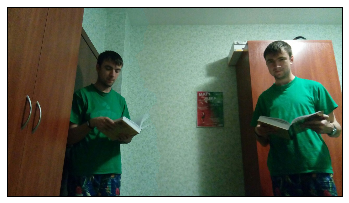

In [74]:
show(image)

In [48]:
imagesPaths = ['left.jpg', 'right.jpg']
masksPaths = ['leftMask.jpg', 'rightMask.jpg']
masksPaths = ['Images/2photo/'+p for p in masksPaths]
imagesPaths = ['Images/2photo/'+p for p in imagesPaths]

In [56]:
generate_data(imagesPaths, masksPaths,'Images/2photo/')